In [1]:
import torch
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [2]:
# Importer Un dataset préfait (MNIST)

training_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=T.ToTensor()
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor()
)

In [3]:
print(training_dataset)
print(training_dataset.data.shape)
print(training_dataset.targets.shape)
print(training_dataset.targets.unique())
print(training_dataset.targets.bincount())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])


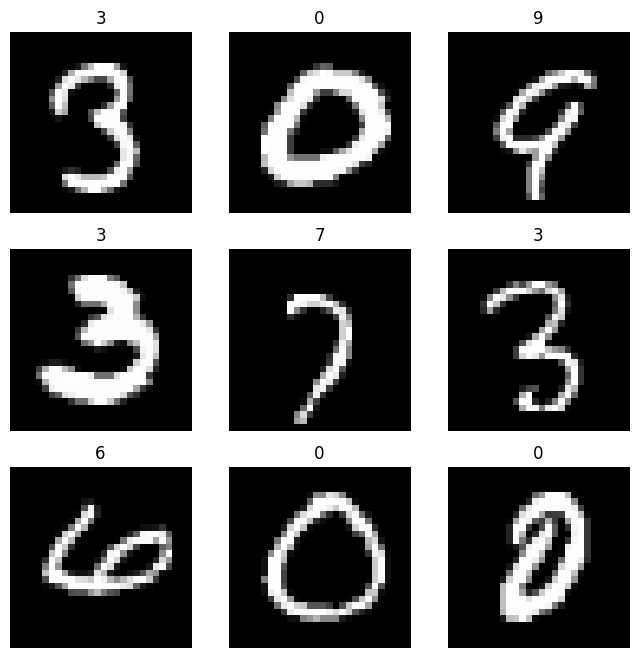

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_dataset), size=(1,)).item()
    img, label = training_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"shape X : {X.shape}")
    print(f"y shape: {y.shape}")
    break

shape X : torch.Size([64, 1, 28, 28])
y shape: torch.Size([64])


In [6]:
train_features, train_labels = next(iter(train_dataloader))
train_features.shape

torch.Size([64, 1, 28, 28])

In [7]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, dims):
        super(MLP, self).__init__()
        self.fcs = nn.ModuleList(
            [nn.Linear(dims[i], dims[i+1]) for i in range(len(dims)-1)]
        )
        self.act = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x) #1 * 28 * 28 -> 1 * 784 
        for layer in self.fcs:
            x  = layer(x)
            x = self.act(x)
        return x

In [8]:
input_dim = 28*28
output_dim = 10 #Nombre de classe
model = MLP([input_dim, 128, 128, output_dim])

In [9]:
model

MLP(
  (fcs): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
  (act): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [10]:
loss_fn = nn.CrossEntropyLoss() # Expect raw logits (!= probabilities)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) 

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()

    for batch, (X, y) in enumerate(dataloader):

        #Prédiction
        ypred = model(X)
        loss = loss_fn(ypred, y) #Calcul de l'erreur

        #backpropagation
        loss.backward()
        optimizer.step() #W = W - lr * grad
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size * len(X)
            print(f'loss {loss:>7f} [{current:>5d}/{len(dataloader.dataset)}]')

def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            ypred = model(X)
            test_loss += loss_fn(ypred, y).item()
            correct += (ypred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss/= len(dataloader)
    correct/=len(dataloader.dataset)
    print(f"Test loss: {test_loss:>8f} | test accuracy {(correct * 100):>7f}")

In [14]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1} ------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1 ------------------------
loss 2.289620 [    0/60000]
loss 1.222234 [409600/60000]
loss 1.095790 [819200/60000]
loss 1.032211 [1228800/60000]
loss 1.100716 [1638400/60000]
loss 1.166392 [2048000/60000]
loss 0.927789 [2457600/60000]
loss 1.043676 [2867200/60000]
loss 1.080524 [3276800/60000]
loss 0.817952 [3686400/60000]
Test loss: 1.040101 | test accuracy 66.770000
Epoch 2 ------------------------
loss 0.714968 [    0/60000]
loss 0.958274 [409600/60000]
loss 1.132699 [819200/60000]
loss 1.249062 [1228800/60000]
loss 0.933068 [1638400/60000]
loss 0.930488 [2048000/60000]
loss 0.891248 [2457600/60000]
loss 0.822153 [2867200/60000]
loss 1.039434 [3276800/60000]
loss 1.126378 [3686400/60000]
Test loss: 0.982651 | test accuracy 68.750000
Epoch 3 ------------------------
loss 0.937032 [    0/60000]
loss 0.891880 [409600/60000]
loss 1.186265 [819200/60000]
loss 0.988578 [1228800/60000]
loss 0.960681 [1638400/60000]
loss 0.944863 [2048000/60000]
loss 0.942443 [2457600/60000]
loss 0.8444